In [73]:
import requests
import pandas as pd
import io
import sdmx



# ================================
# Function to Retrieve Available Dataflows
# ================================
def get_available_dataflows(client):
    """
    Fetch available dataflows (datasets) from ECB or Eurostat.
    """
    try:
        dataflow_message = client.dataflow()
        dataflows_df = sdmx.to_pandas(dataflow_message.dataflow)
        dataflows_df.name = f"{client.source.id} Dataflows"

        # Extract full names for reference
        dataflows_full_names = {key: value.name.en for key, value in dataflow_message.dataflow.items()}
        print(f"\n✅ Available dataflows for {client.source.id}:")
        for key, name in dataflows_full_names.items():
            print(f"🔹 {key}: {name}")

        return dataflows_df

    except Exception as e:
        print(f"⚠️ Error retrieving dataflows from {client.source.id}: {e}")
        return None


# ================================
# Function to Retrieve Dataflow Metadata
# ================================
def get_dataflow_metadata(client, dataflow_id):
    """
    Retrieve dataset structure and constraints for a given dataset ID.
    """
    print(f"\n📊 Retrieving metadata for dataset: '{dataflow_id}' from {client.source.id}")

    try:
        dataflow_message = client.dataflow(dataflow_id)
        structure = dataflow_message.dataflow[dataflow_id].structure
        name = dataflow_message.dataflow[dataflow_id].name

        # Handle missing constraints
        constraints = dataflow_message.constraint.get(f"{dataflow_id}_CONSTRAINTS", None)
        if constraints is None:
            print(f"⚠️ No constraints found for dataset: {dataflow_id}")
            constraints_region = None
        else:
            constraints_region = constraints.data_content_region[0]

        return structure, constraints_region, name

    except Exception as e:
        print(f"❌ Error retrieving metadata for dataset '{dataflow_id}': {e}")
        return None, None, None


# ================================
# Function to Retrieve Available Dimensions
# ================================
def get_dataflow_dimensions(data_structure_definition, dataflow_name):
    """
    Retrieve dimensions (variables) for a dataset.
    """
    if data_structure_definition is None:
        print(f"⚠️ No structure available for '{dataflow_name}'")
        return None

    dimensions = data_structure_definition.dimensions
    print(f"\n📌 Dimensions for dataset '{dataflow_name}':")

    dimension_dict = {dimension.id: dimension.concept_identity.name for dimension in dimensions}
    for key, value in dimension_dict.items():
        print(f"🔹 {key}: {value}")

    return pd.Series(dimension_dict, name=f"'{dataflow_name}' Dimensions")


# ================================
# Function to Retrieve Constraints (Allowed Values for Dimensions)
# ================================
def get_constraint_codes(constraints, dimension):
    """
    Extract available values for a dimension from constraints.
    """
    if constraints is None:
        return pd.Series(name=f"'{dimension.id}' Codes", dtype='object')

    try:
        codes = constraints.member[dimension.id].values
        codes_with_description = {code.value: code.value for code in codes}
        return pd.Series(codes_with_description, name=f"'{dimension.id}' Codes")

    except Exception:
        return pd.Series(name=f"'{dimension.id}' Codes", dtype='object')


def get_constraints_with_codes(data_structure_definition, constraints):
    """
    Retrieve all constraints (allowed values) for dataset dimensions.
    """
    if data_structure_definition is None:
        print("⚠️ No structure found for dataset.")
        return None

    dimensions = data_structure_definition.dimensions
    print("\n📌 Available values for each dimension:")

    constraints_list = []
    for dimension in dimensions:
        codes = get_constraint_codes(constraints, dimension)
        constraints_list.append(codes)
        if not codes.empty:
            print(f"🔹 {dimension.id}: {list(codes.index)}")

    return constraints_list


# ================================
# Function to Retrieve Valid Series Keys (Combinations of Values)
# ================================
def parse_series_key(series_key):
    """
    Parse series keys into a dictionary.
    """
    return {value.id: value.value for value in series_key.values.values()}


def get_dataflow_series_keys(client, dataflow_id, dataflow_name):
    """
    Retrieve valid series keys (valid combinations of values).
    """
    try:
        data_message = client.series_keys(dataflow_id)
        series_keys = [parse_series_key(series_key) for series_key in list(data_message)]
        df = pd.DataFrame.from_records(series_keys)
        df.name = f"'{dataflow_name}' Series Keys"
        print(f"\n✅ Retrieved {len(df)} valid series keys for '{dataflow_id}'")
        return df

    except Exception as e:
        print(f"⚠️ Error retrieving series keys for dataset '{dataflow_id}': {e}")
        return None



In [74]:

# ================================
# Choose API: ECB or Eurostat
# ================================
source = "ECB"  # Change to "ECB" or "ESTAT" based on the required data
client = sdmx.Client(source)

# Retrieve available datasets
dataflows = get_available_dataflows(client)

# Choose dataset for metadata extraction
dataset_id = "ICP"  # Change this to the dataset you want

# Retrieve dataset structure and constraints
data_structure_definition, constraints, dataset_name = get_dataflow_metadata(client, dataset_id)

# Retrieve dataset dimensions
dimensions = get_dataflow_dimensions(data_structure_definition, dataset_name)

# Retrieve valid values (constraints) for each dimension
constraints_with_codes = get_constraints_with_codes(data_structure_definition, constraints)

# Retrieve valid series keys
series_keys = get_dataflow_series_keys(client, dataset_id, dataset_name)

# ================================
# Print final results
# ================================
print("\n✅ Finished processing dataset:", dataset_id)
print("\n📊 Available dimensions:")
print(dimensions)

print("\n📌 Constraints (Allowed values for dimensions):")
print(constraints_with_codes)

print("\n📊 Valid Series Keys (Combinations of values):")
print(series_keys)

import pandas as pd

# Assuming 'series_keys' is a Pandas Series
series_keys.to_csv(r'C:/Users/marta/OneDrive/Робочий стіл/ICP_series_keys.csv', index=False, header=False)

###### NOTES ON WHICH VALUES TO INCLUDE VIA DATASET



✅ Available dataflows for ECB:
🔹 AME: AMECO
🔹 BKN: Banknotes statistics
🔹 BLS: Bank Lending Survey Statistics
🔹 BNT: Shipments of Euro Banknotes Statistics (ESCB)
🔹 BOP: Euro Area Balance of Payments and International Investment Position Statistics
🔹 BPS: Balance of Payments and International Investment Position
🔹 BSI: Balance Sheet Items
🔹 BSP: Balance Sheet Items Statistics (tables 2 to 5 of the Blue Book)
🔹 CBD: Statistics on Consolidated Banking Data
🔹 CBD2: Consolidated Banking data
🔹 CCP: Central Counterparty Clearing Statistics
🔹 CISS: Composite Indicator of Systemic Stress
🔹 CLIFS: Country-Level Index of Financial Stress (CLIFS)
🔹 CPP: Commercial Property Price Statistics
🔹 CSEC: CSEC
🔹 DCM: Dealogic DCM analytics data
🔹 DD: Derived Data
🔹 DWA: DWA
🔹 E11: Classification of the Functions of Government Statistics (Eurostat ESA2010 TP, table 11)
🔹 ECB_STBS1: ECB_STBS1
🔹 EON: EONIA: Euro Interbank Offered Rate
🔹 ESA: ESA95 National Accounts
🔹 ESB: European Union Balance of Payment

In [1]:


def ECB_Data_Loader(dataset, years, key):
    print('########################################################################################')
    import requests
    import pandas as pd
    import io
    # Building blocks for the URL
    start_MM_DD = ['01-01','02-01','03-01','04-01','05-01','06-01',
                   '07-01','08-01','09-01','10-01','11-01','12-01']
    end_MM_DD = ['01-31', '02-28', '03-31', '04-30','05-31', '06-30',
                 '07-31', '08-31','09-30', '10-31', '11-30', '12-31']

    # Initialize DataFrame
    BSI_df = pd.DataFrame()

    for year in years:
        entrypoint = 'https://sdw-wsrest.ecb.europa.eu/service/'
        resource = 'data'
        flowRef = dataset

        for i in range(12):  # Corrected month iteration
            parameters = {
                'startPeriod': f"{year}-{start_MM_DD[i]}",
                'endPeriod': f"{year}-{end_MM_DD[i]}",
            }
            request_url = entrypoint + resource + '/' + flowRef + '/' + key

            # Make the HTTP request
            response = requests.get(request_url, params=parameters, headers={'Accept': 'text/csv'})
            if not response.text.strip():
                print(f"⚠ No data for {parameters['startPeriod']} to {parameters['endPeriod']}, skipping...")
                continue  # No need to increment, loop handles it

            print(f"startPeriod-endPeriod: {parameters['startPeriod']} to {parameters['endPeriod']}, response = {response.status_code}")

            try:
                df = pd.read_csv(io.StringIO(response.text))
            except pd.errors.EmptyDataError:
                print(f"⚠ No valid CSV data for {parameters['startPeriod']} to {parameters['endPeriod']}, skipping...")
                continue

            # **Check if 'OBS_VALUE' column exists before accessing**
            if 'OBS_VALUE' not in df.columns:
                print(f"⚠ 'OBS_VALUE' missing in response for {parameters['startPeriod']} to {parameters['endPeriod']}, skipping...")
                print("Available columns:", df.columns)  # Debugging step
                continue

            obs_value = df['OBS_VALUE'].values[0]

            print('==============================')

            BSI_df = pd.concat([BSI_df, pd.DataFrame([{
                'start_period': f"{year}-{start_MM_DD[i]}",  # Use 'i' instead of 'iter'
                'end_data': f"{year}-{end_MM_DD[i]}",
                'dataset': flowRef,
                'query': key,
                'OBS_value': obs_value
            }])], ignore_index=True)

    return BSI_df  # Return the DataFrame




In [80]:
import pandas as pd
flow = 'ICP'
y_range = ['2017','2018','2019','2020', '2021', '2022','2023']


bsi_codelist = ['Q.U2.S.1000.P31000.D.N.I', 'Q.U2.Y.1000.B1QG00.Y.N.A', 'Q.U2.S.1000.P60000.D.N.I',
                'Q.U2.S.1000.P52_53.D.N.I','Q.U2.Y.1000.TOTEMP.L.N.A', 'Q.U2.S.1000.D21X31.D.N.I',
                'Q.U2.Y.1000.COMPHW.Y.N.A', 'Q.U2.S.1000.EMPLOY.Y.N.A', 'Q.U2.S.1000.P51000.D.N.I',
                'Q.U2.Y.1000.P30_50.D.N.I', 'Q.U2.S.1000.UNLACO.D.N.I'
                , 'Q.U2.S.1000.UNLAHW.D.N.I', 'Q.U2.Y.1000.LABPHW.Y.N.A', 'Q.U2.S.1000.LABPRO.Y.N.A'
                , 'Q.U2.S.1000.B1G000.Y.N.A', 'Q.U2.S.1000.P70000.D.N.I', 'Q.U2.S.1000.P30_51.D.N.I'
                , 'Q.U2.S.1000.D10000.D.N.I', 'Q.U2.S.1000.P40000.D.N.I', 'Q.U2.Y.1000.B90000.Y.N.A'
                ]

mir_codelist = ['M.U2.B.L24.A.N.A.2230.EUR.N','M.U2.B.L24.A.O.A.2230.EUR.N', 'M.U2.B.L24.A.R.A.2230.EUR.N',
                 'M.U2.B.L24.A.V.A.2230.EUR.N','M.U2.B.L22.A.V.A.2230.EUR.N', 'M.U2.B.L22.A.V.A.2240.EUR.N',
                 'M.U2.B.L22.A.V.A.2250.EUR.N','M.U2.B.L22.F.R.A.2230.EUR.N', 'M.U2.B.L22.F.R.A.2240.EUR.N',
                 'M.U2.B.L22.F.R.A.2250.EUR.N','M.U2.B.L22.F.V.A.2230.EUR.N', 'M.U2.B.L22.F.V.A.2240.EUR.N',
                 'M.U2.B.L22.F.V.A.2250.EUR.N','M.U2.B.A2B.A.R.A.2250.EUR.N', 'M.U2.B.A2B.A.R.A.2250.EUR.P',
                 'M.U2.B.A2B.A.R.A.2250.EUR.R','M.U2.B.A2C.A.R.A.2250.EUR.N', 'M.U2.B.A2C.A.R.A.2250.EUR.P',
                 'M.U2.B.A2C.A.R.A.2250.EUR.R','M.U2.B.A2AC.A.R.A.2240.EUR.N'
                 ]

final_df = pd.DataFrame()

for code in mir_codelist:
    temp_df = ECB_Data_Loader(flow, y_range, code)
    final_df = pd.concat([final_df, temp_df], ignore_index=True)


final_df.to_csv("C:/Users/marta/OneDrive/Робочий стіл/mir_data.csv", index=False)  # Windows



########################################################################################
startPeriod-endPeriod: 2017-01-01 to 2017-01-31, response = 400
⚠ 'OBS_VALUE' missing in response for 2017-01-01 to 2017-01-31, skipping...
Available columns: Index(['<html lang="en"><head><title>European Central Bank</title><style type="text/css"> body{ font-family: "Droid Sans"',
       ' sans-serif; margin:0; padding:0; background-color: #9099ab; text-align: center; } h1{  font-size:38px; font-weight: normal; color:#003299; }  @media screen and (max-width: 480px) { h1{ font-size: 30px; } }  p { font-size: 15px; line-height: 20px; color: #333; margin-bottom: 20px; }  p.signature{ font-style: italic; color:#DF0101; }  .centredFrame { margin: 0 auto; text-align: center; width: 70%;   } .content{ margin-top:40px; padding:40px; background-color: #fff; border:1px solid #CDE3E0; -moz-border-radius: 20px; border-radius: 20px; } </style><link href="//fonts.googleapis.com/css?family=Droid+Sans" rel="style

KeyboardInterrupt: 

In [ ]:
import pandas as pd
flow = 'ICP'
y_range = ['2017','2018','2019','2020', '2021', '2022','2023']


bsi_codelist = ['Q.U2.S.1000.P31000.D.N.I', 'Q.U2.Y.1000.B1QG00.Y.N.A', 'Q.U2.S.1000.P60000.D.N.I',
                'Q.U2.S.1000.P52_53.D.N.I','Q.U2.Y.1000.TOTEMP.L.N.A', 'Q.U2.S.1000.D21X31.D.N.I',
                'Q.U2.Y.1000.COMPHW.Y.N.A', 'Q.U2.S.1000.EMPLOY.Y.N.A', 'Q.U2.S.1000.P51000.D.N.I',
                'Q.U2.Y.1000.P30_50.D.N.I', 'Q.U2.S.1000.UNLACO.D.N.I'
                , 'Q.U2.S.1000.UNLAHW.D.N.I', 'Q.U2.Y.1000.LABPHW.Y.N.A', 'Q.U2.S.1000.LABPRO.Y.N.A'
                , 'Q.U2.S.1000.B1G000.Y.N.A', 'Q.U2.S.1000.P70000.D.N.I', 'Q.U2.S.1000.P30_51.D.N.I'
                , 'Q.U2.S.1000.D10000.D.N.I', 'Q.U2.S.1000.P40000.D.N.I', 'Q.U2.Y.1000.B90000.Y.N.A'
                ]

mir_codelist = ['M.U2.B.L24.A.N.A.2230.EUR.N','M.U2.B.L24.A.O.A.2230.EUR.N', 'M.U2.B.L24.A.R.A.2230.EUR.N',
                 'M.U2.B.L24.A.V.A.2230.EUR.N','M.U2.B.L22.A.V.A.2230.EUR.N', 'M.U2.B.L22.A.V.A.2240.EUR.N',
                 'M.U2.B.L22.A.V.A.2250.EUR.N','M.U2.B.L22.F.R.A.2230.EUR.N', 'M.U2.B.L22.F.R.A.2240.EUR.N',
                 'M.U2.B.L22.F.R.A.2250.EUR.N','M.U2.B.L22.F.V.A.2230.EUR.N', 'M.U2.B.L22.F.V.A.2240.EUR.N',
                 'M.U2.B.L22.F.V.A.2250.EUR.N','M.U2.B.A2B.A.R.A.2250.EUR.N', 'M.U2.B.A2B.A.R.A.2250.EUR.P',
                 'M.U2.B.A2B.A.R.A.2250.EUR.R','M.U2.B.A2C.A.R.A.2250.EUR.N', 'M.U2.B.A2C.A.R.A.2250.EUR.P',
                 'M.U2.B.A2C.A.R.A.2250.EUR.R','M.U2.B.A2AC.A.R.A.2240.EUR.N'
                 ]


icp_codelist_ALL = [
    "M.U2.N.040000.3.CTG", "M.U2.N.040000.4.ANR", "M.U2.N.040000.4.INX",
    "M.U2.N.045000.3.CTG", "M.U2.N.045000.4.ANR", "M.U2.N.045000.4.INX",
    "M.U2.N.045100.3.CTG", "M.U2.N.045100.4.ANR", "M.U2.N.045100.4.INX",
    "M.U2.N.ELGAS0.4.ANR", "M.U2.N.ELGAS0.4.INX",
    "M.U2.N.045200.3.CTG", "M.U2.N.045200.4.ANR", "M.U2.N.045200.4.INX",
    "M.U2.N.045210.4.ANR", "M.U2.N.045210.4.INX",
    "M.U2.N.X04000.4.ANR", "M.U2.N.X04000.4.INX",
    "M.U2.N.045300.3.CTG", "M.U2.N.045300.4.ANR", "M.U2.N.045300.4.INX",
    "M.U2.N.045400.3.CTG", "M.U2.N.045400.4.ANR", "M.U2.N.045400.4.INX",
    "M.U2.N.072200.3.CTG", "M.U2.N.072200.4.ANR", "M.U2.N.072200.4.INX",
    "M.U2.N.010000.3.CTG", "M.U2.N.010000.4.ANR", "M.U2.N.010000.4.INX",
    "M.U2.N.011000.3.CTG", "M.U2.N.011000.4.ANR", "M.U2.N.011000.4.INX",
    "M.U2.N.071100.3.CTG", "M.U2.N.071100.4.ANR", "M.U2.N.071100.4.INX",
    "M.U2.N.071110.4.ANR", "M.U2.N.071110.4.INX",
    "M.U2.N.071120.4.ANR", "M.U2.N.071120.4.INX",
    "M.U2.N.124010.4.ANR", "M.U2.N.124010.4.INX"
]

icp_codelist_1 = [
    "M.U2.N.040000.3.CTG", "M.U2.N.040000.4.ANR", "M.U2.N.040000.4.INX",
    "M.U2.N.045000.3.CTG", "M.U2.N.045000.4.ANR", "M.U2.N.045000.4.INX",
    "M.U2.N.045100.3.CTG", "M.U2.N.045100.4.ANR", "M.U2.N.045100.4.INX",
    "M.U2.N.ELGAS0.4.ANR", "M.U2.N.ELGAS0.4.INX",
    "M.U2.N.045200.3.CTG", "M.U2.N.045200.4.ANR", "M.U2.N.045200.4.INX"]

icp_codelist_2 = [

    "M.U2.N.045210.4.ANR", "M.U2.N.045210.4.INX",
    "M.U2.N.X04000.4.ANR", "M.U2.N.X04000.4.INX",
    "M.U2.N.045300.3.CTG", "M.U2.N.045300.4.ANR", "M.U2.N.045300.4.INX",
    "M.U2.N.045400.3.CTG", "M.U2.N.045400.4.ANR", "M.U2.N.045400.4.INX",

]


icp_codelist_3 = [

    "M.U2.N.072200.3.CTG", "M.U2.N.072200.4.ANR", "M.U2.N.072200.4.INX",
    "M.U2.N.010000.3.CTG", "M.U2.N.010000.4.ANR", "M.U2.N.010000.4.INX",
    "M.U2.N.011000.3.CTG", "M.U2.N.011000.4.ANR", "M.U2.N.011000.4.INX",
    "M.U2.N.071100.3.CTG", "M.U2.N.071100.4.ANR", "M.U2.N.071100.4.INX"

]




icp_codelist_4 = [

    "M.U2.N.010000.3.CTG", "M.U2.N.010000.4.ANR", "M.U2.N.010000.4.INX",
    "M.U2.N.011000.3.CTG", "M.U2.N.011000.4.ANR", "M.U2.N.011000.4.INX",
    "M.U2.N.071100.3.CTG", "M.U2.N.071100.4.ANR", "M.U2.N.071100.4.INX",
    "M.U2.N.071110.4.ANR", "M.U2.N.071110.4.INX",
    "M.U2.N.071120.4.ANR", "M.U2.N.071120.4.INX",
    "M.U2.N.124010.4.ANR", "M.U2.N.124010.4.INX"
]


final_df = pd.DataFrame()

for code in icp_codelist_1:
    temp_df = ECB_Data_Loader(flow, y_range, code)
    final_df = pd.concat([final_df, temp_df], ignore_index=True)


final_df.to_csv("C:/Users/marta/OneDrive/Робочий стіл/icp_data.csv", index=False)  # Windows



########################################################################################
########################################################################################
########################################################################################
########################################################################################
########################################################################################
########################################################################################
########################################################################################
########################################################################################
########################################################################################
########################################################################################
########################################################################################
#####################

In [9]:
icp_inflation_idx = 'M.U2.N.000000.4.ANR'
import pandas as pd
flow = 'ICP'
y_range = ['2017','2018','2019','2020', '2021', '2022','2023']


final_df = ECB_Data_Loader(flow, y_range, icp_inflation_idx)
final_df.to_csv("C:/Users/marta/OneDrive/Робочий стіл/icp__data.csv", index=False)  # Windows



########################################################################################
startPeriod-endPeriod: 2017-01-01 to 2017-01-31, response = 200
startPeriod-endPeriod: 2017-02-01 to 2017-02-28, response = 200
startPeriod-endPeriod: 2017-03-01 to 2017-03-31, response = 200
startPeriod-endPeriod: 2017-04-01 to 2017-04-30, response = 200
startPeriod-endPeriod: 2017-05-01 to 2017-05-31, response = 200
startPeriod-endPeriod: 2017-06-01 to 2017-06-30, response = 200
startPeriod-endPeriod: 2017-07-01 to 2017-07-31, response = 200
startPeriod-endPeriod: 2017-08-01 to 2017-08-31, response = 200
startPeriod-endPeriod: 2017-09-01 to 2017-09-30, response = 200
startPeriod-endPeriod: 2017-10-01 to 2017-10-31, response = 200
startPeriod-endPeriod: 2017-11-01 to 2017-11-30, response = 200
startPeriod-endPeriod: 2017-12-01 to 2017-12-31, response = 200
startPeriod-endPeriod: 2018-01-01 to 2018-01-31, response = 200
startPeriod-endPeriod: 2018-02-01 to 2018-02-28, response = 200
startPeriod-end

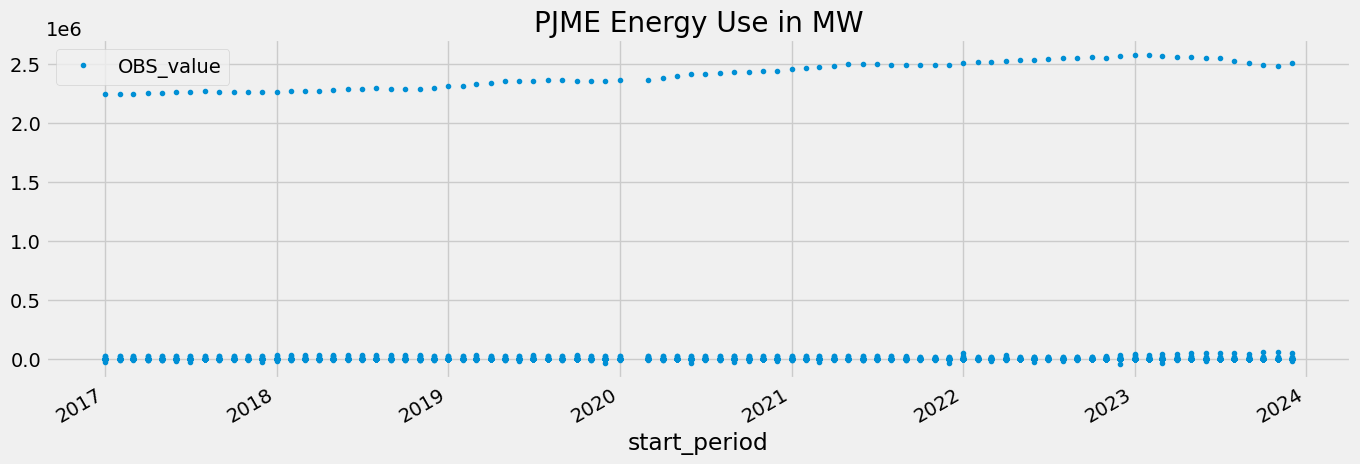

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


# Load CSV files
df1 = pd.read_csv("C:/Users/marta/OneDrive/Робочий стіл/Economi_Indicators/data_pulls/bsi_data.csv")  # Replace with your actual filenames
df2 = pd.read_csv("C:/Users/marta/OneDrive/Робочий стіл/Economi_Indicators/data_pulls/exr_data.csv")
df3 = pd.read_csv("C:/Users/marta/OneDrive/Робочий стіл/Economi_Indicators/data_pulls/mir_data.csv")

ecb_data = pd.concat([df1, df2, df3], ignore_index=True)


ecb_data = ecb_data.set_index('start_period')
ecb_data.index = pd.to_datetime(ecb_data.index)

ecb_data.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

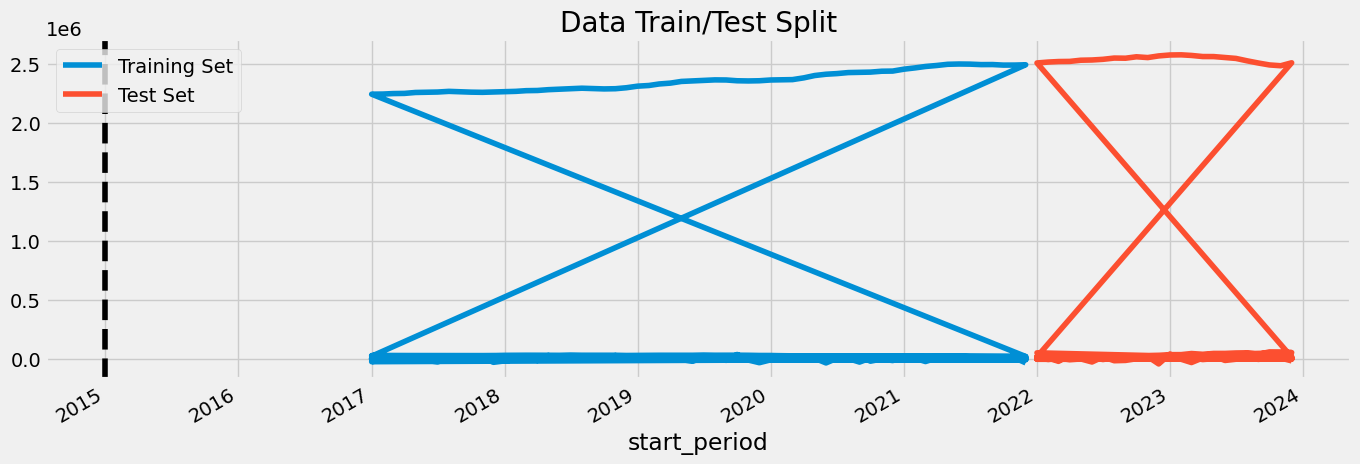

In [34]:
train = ecb_data.loc[ecb_data.index < '01-01-2022']
test = ecb_data.loc[ecb_data.index >= '01-01-2022']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

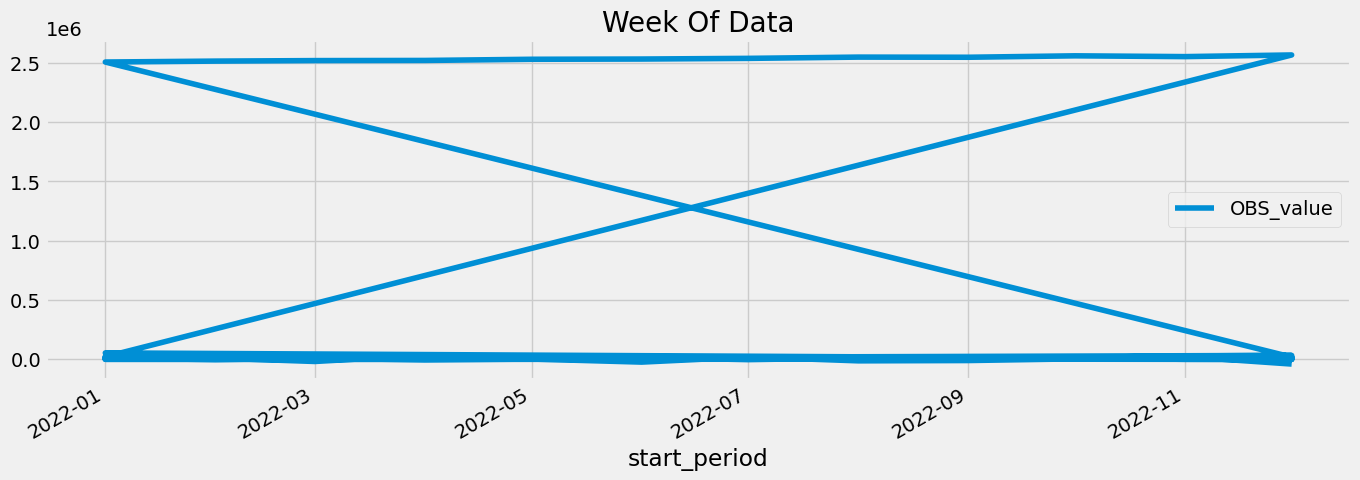

In [38]:
ecb_data.loc[(ecb_data.index >= '01-01-2022') & (ecb_data.index <= '12-31-2022')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

ValueError: cannot reindex on an axis with duplicate labels

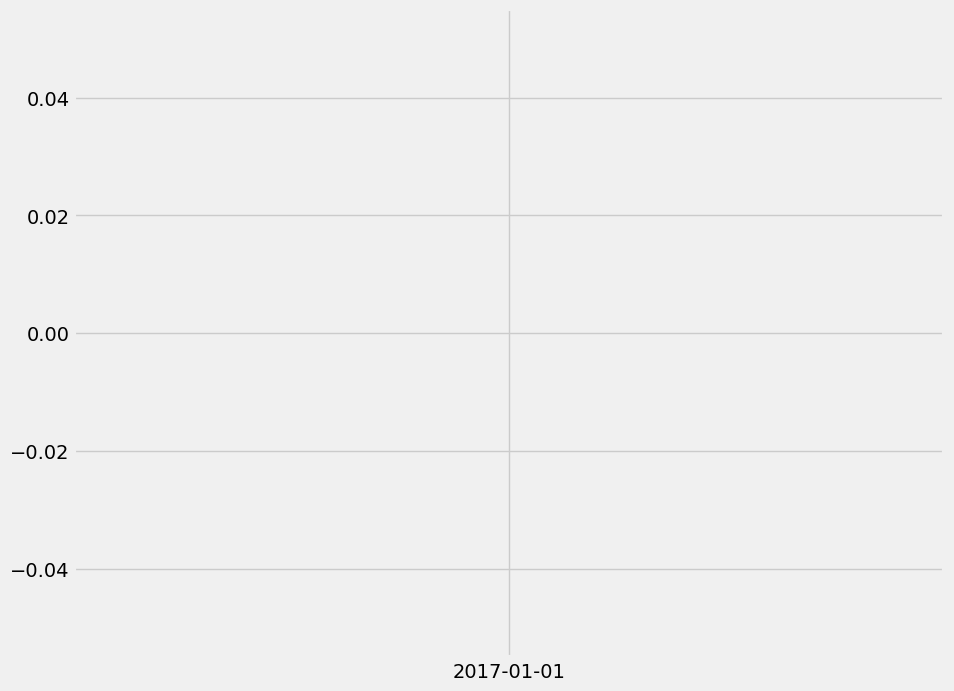

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=ecb_data, x='start_period', y='OBS_value')
ax.set_title('MW by Hour')
plt.show()

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


# Load CSV files
df1 = pd.read_csv("C:/Users/marta/OneDrive/Робочий стіл/Economi_Indicators/data_pulls/bsi_data.csv")  # Replace with your actual filenames
df2 = pd.read_csv("C:/Users/marta/OneDrive/Робочий стіл/Economi_Indicators/data_pulls/exr_data.csv")
df3 = pd.read_csv("C:/Users/marta/OneDrive/Робочий стіл/Economi_Indicators/data_pulls/mir_data.csv")

ecb_data = pd.concat([df1, df2, df3], ignore_index=True)



# Extract HICP inflation data
hicp_data = df3[df3['dataset'] == 'MIR'].copy()

# Drop unnecessary columns
hicp_data = hicp_data[['start_period', 'OBS_value']].rename(columns={'OBS_value': 'HICP_inflation'})


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Set style
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Load CSV files
df1 = pd.read_csv("C:/Users/marta/OneDrive/Робочий стіл/Economi_Indicators/data_pulls/bsi_data.csv")
df2 = pd.read_csv("C:/Users/marta/OneDrive/Робочий стіл/Economi_Indicators/data_pulls/exr_data.csv")
df3 = pd.read_csv("C:/Users/marta/OneDrive/Робочий стіл/Economi_Indicators/data_pulls/mir_data.csv")

# Combine datasets
ecb_data = pd.concat([df1, df2, df3], ignore_index=True)

# Extract HICP inflation data
hicp_data = df3[df3['dataset'] == 'MIR'].copy()
hicp_data = hicp_data[['start_period', 'OBS_value']].rename(columns={'OBS_value': 'HICP_inflation'})

# Convert start_period to datetime before merging
ecb_data['start_period'] = pd.to_datetime(ecb_data['start_period'], dayfirst=False, errors='coerce')
hicp_data['start_period'] = pd.to_datetime(hicp_data['start_period'], dayfirst=False, errors='coerce')

# Drop NaT values
ecb_data = ecb_data.dropna(subset=['start_period'])
hicp_data = hicp_data.dropna(subset=['start_period'])

# Pivot dataset to have indicators as separate columns
ecb_pivot = ecb_data.pivot(index='start_period', columns='query', values='OBS_value').reset_index()

# Merge with HICP inflation data
ecb_pivot = pd.merge(ecb_pivot, hicp_data, on="start_period", how="inner")

# Sort data by date
ecb_pivot = ecb_pivot.sort_values(by=["start_period"])

ecb_pivot.to_csv("C:/Users/marta/OneDrive/Робочий стіл/pivot_data.csv", index=False)  # Windows


# **Fix: Generate all lag features at once to prevent fragmentation**
lag_features = list(ecb_pivot.columns[1:-1])  # Exclude 'start_period' and 'HICP_inflation'
lags = [1, 2, 3]  # Create lags for the past 3 months

print(lag_features)
lagged_dfs = []
for lag in lags:
    lagged_df = ecb_pivot[lag_features].shift(lag)
    lagged_df.columns = [f"{col}_lag_{lag}" for col in lagged_df.columns]
    lagged_dfs.append(lagged_df)

# Concatenate all lagged features at once
ecb_pivot = pd.concat([ecb_pivot] + lagged_dfs, axis=1)

# Drop NaN values caused by lagging
ecb_pivot.dropna(inplace=True)

# Ensure start_period is datetime
ecb_pivot['start_period'] = pd.to_datetime(ecb_pivot['start_period'], errors='coerce')

# **Check date parsing is correct**
print(f"Min date: {ecb_pivot['start_period'].min()} | Max date: {ecb_pivot['start_period'].max()}")

# Train-test split (before and from 2022)
train = ecb_pivot[ecb_pivot['start_period'] < pd.Timestamp('2022-01-01')]
test = ecb_pivot[ecb_pivot['start_period'] >= pd.Timestamp('2022-01-01')]

# **Check if training and testing data exist before proceeding**
if train.shape[0] == 0 or test.shape[0] == 0:
    raise ValueError("No training or test data available! Check date parsing.")

# Define predictors (X) and target (y)
X_train = train.drop(columns=['start_period', 'HICP_inflation'])
y_train = train['HICP_inflation']
X_test = test.drop(columns=['start_period', 'HICP_inflation'])
y_test = test['HICP_inflation']

# **Ensure data is not empty**
print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

# Train XGBoost
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")


['M.AUD.EUR.SP00.A', 'M.BGN.EUR.SP00.A', 'M.CAD.EUR.SP00.A', 'M.CHF.EUR.SP00.A', 'M.CNY.EUR.SP00.A', 'M.DKK.EUR.SP00.A', 'M.GBP.EUR.SP00.A', 'M.HKD.EUR.SP00.A', 'M.INR.EUR.SP00.A', 'M.JPY.EUR.SP00.A', 'M.MXN.EUR.SP00.A', 'M.NOK.EUR.SP00.A', 'M.PLN.EUR.SP00.A', 'M.RON.EUR.SP00.A', 'M.RUB.EUR.SP00.A', 'M.SEK.EUR.SP00.A', 'M.TRY.EUR.SP00.A', 'M.U2.B.A2AC.A.R.A.2240.EUR.N', 'M.U2.B.A2B.A.R.A.2250.EUR.N', 'M.U2.B.A2B.A.R.A.2250.EUR.P', 'M.U2.B.A2B.A.R.A.2250.EUR.R', 'M.U2.B.A2C.A.R.A.2250.EUR.N', 'M.U2.B.A2C.A.R.A.2250.EUR.P', 'M.U2.B.A2C.A.R.A.2250.EUR.R', 'M.U2.B.L22.A.V.A.2230.EUR.N', 'M.U2.B.L22.A.V.A.2240.EUR.N', 'M.U2.B.L22.A.V.A.2250.EUR.N', 'M.U2.B.L22.F.R.A.2230.EUR.N', 'M.U2.B.L22.F.R.A.2240.EUR.N', 'M.U2.B.L22.F.R.A.2250.EUR.N', 'M.U2.B.L22.F.V.A.2230.EUR.N', 'M.U2.B.L22.F.V.A.2240.EUR.N', 'M.U2.B.L22.F.V.A.2250.EUR.N', 'M.U2.B.L24.A.N.A.2230.EUR.N', 'M.U2.B.L24.A.O.A.2230.EUR.N', 'M.U2.B.L24.A.R.A.2230.EUR.N', 'M.U2.B.L24.A.V.A.2230.EUR.N', 'M.U2.N.A.L22.L.4.U2.2250.EUR.E', 'M.U

ValueError: No training or test data available! Check date parsing.

In [59]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Set style
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Load CSV files
df1 = pd.read_csv("C:/Users/marta/OneDrive/Робочий стіл/Economi_Indicators/data_pulls/bsi_data.csv")
df2 = pd.read_csv("C:/Users/marta/OneDrive/Робочий стіл/Economi_Indicators/data_pulls/exr_data.csv")
df3 = pd.read_csv("C:/Users/marta/OneDrive/Робочий стіл/Economi_Indicators/data_pulls/mir_data.csv")

# Combine datasets
ecb_data = pd.concat([df1, df2, df3], ignore_index=True)

# Extract HICP inflation data
hicp_data = df3[df3['dataset'] == 'MIR'].copy()
hicp_data = hicp_data[['start_period', 'OBS_value']].rename(columns={'OBS_value': 'HICP_inflation'})

# Convert start_period to datetime before merging
ecb_data['start_period'] = pd.to_datetime(ecb_data['start_period'], dayfirst=False, errors='coerce')
hicp_data['start_period'] = pd.to_datetime(hicp_data['start_period'], dayfirst=False, errors='coerce')

# Drop NaT values
ecb_data = ecb_data.dropna(subset=['start_period'])
hicp_data = hicp_data.dropna(subset=['start_period'])

# Pivot dataset to have indicators as separate columns
ecb_pivot = ecb_data.pivot(index='start_period', columns='query', values='OBS_value').reset_index()

# Merge with HICP inflation data
ecb_pivot = pd.merge(ecb_pivot, hicp_data, on="start_period", how="inner")

# Sort data by date
df = ecb_pivot.sort_values(by=["start_period"])

# Convert 'start_period' to datetime
df['start_period'] = pd.to_datetime(df['start_period'], errors='coerce')

# Drop rows with NaT in start_period
df = df.dropna(subset=['start_period'])
# print('df after drop na = ', df.head(5))

# Define target column (HICP inflation)
target_column = "HICP_inflation"  # Column to predict

# Ensure target column exists
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset.")

# **Use ALL 44 available indicators as features**
feature_columns = [col for col in df.columns if col not in ["start_period", target_column]]

# Drop rows where target value is NaN
df = df.dropna(subset=[target_column])
# print('df after drop na = ', df.head(5))


# **Create lag features for ALL 44 indicators**
lags = [1, 2, 3]  # Lag for past 3 months
lagged_data = {f"{col}_lag_{lag}": df[col].shift(lag) for lag in lags for col in feature_columns}
lagged_df = pd.DataFrame(lagged_data)

# print('lagged df = ', lagged_df.head())

# Concatenate lagged features to the main dataframe
df = pd.concat([df, lagged_df], axis=1)


# Drop NaN values caused by lagging
# df.dropna(inplace=True)
df = df.dropna(subset=["HICP_inflation"])
# print('df pre-test and train = ', df)



# print('df + lag df and post dropna = ', df.head(10))
df['start_period'] = pd.to_datetime(df['start_period'], format="%m/%d/%Y", errors="coerce")
 # Drop rows with invalid dates
df = df.dropna(subset=['start_period'])

# **Now apply the filtering**
train = df[df['start_period'] < pd.Timestamp("2022-01-01")]
test = df[(df['start_period'] >= pd.Timestamp("2022-01-01")) & (df['start_period'] <= pd.Timestamp("2023-03-01"))]

# print('test = ', test)
# print('train = ', train)
# Define training and testing features/target
X_train = train.drop(columns=["start_period", target_column])  # Use ALL indicators
y_train = train[target_column]

X_test = test.drop(columns=["start_period", target_column])
y_test = test[target_column]

# **Check if training & testing data are valid**
if X_train.empty or X_test.empty:
    raise ValueError("No training or testing data available! Check dataset structure.")

# print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

# **Train XGBoost Model Using ALL 44 Indicators**
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6
)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")

# Show first few predictions
print(predictions)


Mean Absolute Error: 2.1042050135781367
[0.41949844 1.7900844  1.7706665  0.9488014  0.9488014  0.9488014
 0.9488014  0.9488014  0.9488014  0.9488014  0.9488014  0.9488014
 0.9488014  0.9488014  0.9488014  0.9488014  0.9488014  0.9488014
 0.9488014  0.9488014  1.7531136  0.6946953  0.6946953  0.6670164
 0.6670164  0.6670164  0.6670164  0.6670164  0.6670164  0.6670164
 0.6670164  0.6670164  0.6670164  0.6670164  0.6670164  0.6670164
 0.6670164  0.6670164  0.6670164  0.6670164  0.06557148 2.488531
 2.4612982  1.1416829  1.1416829  1.1416829  1.1416829  1.1416829
 1.1416829  1.1416829  1.1416829  1.1416829  1.1416829  1.1416829
 1.1416829  1.1416829  1.1416829  1.1416829  1.1416829  1.1416829
 0.8690453  1.1074421  1.0680766  0.84786767 0.84786767 0.84786767
 0.84786767 0.84786767 0.84786767 0.84786767 0.84786767 0.84786767
 0.84786767 0.84786767 0.84786767 0.84786767 0.84786767 0.84786767
 0.84786767 0.84786767 1.0035883  1.356926   1.726969   1.1121402
 1.1121402  1.1121402  1.1121402  

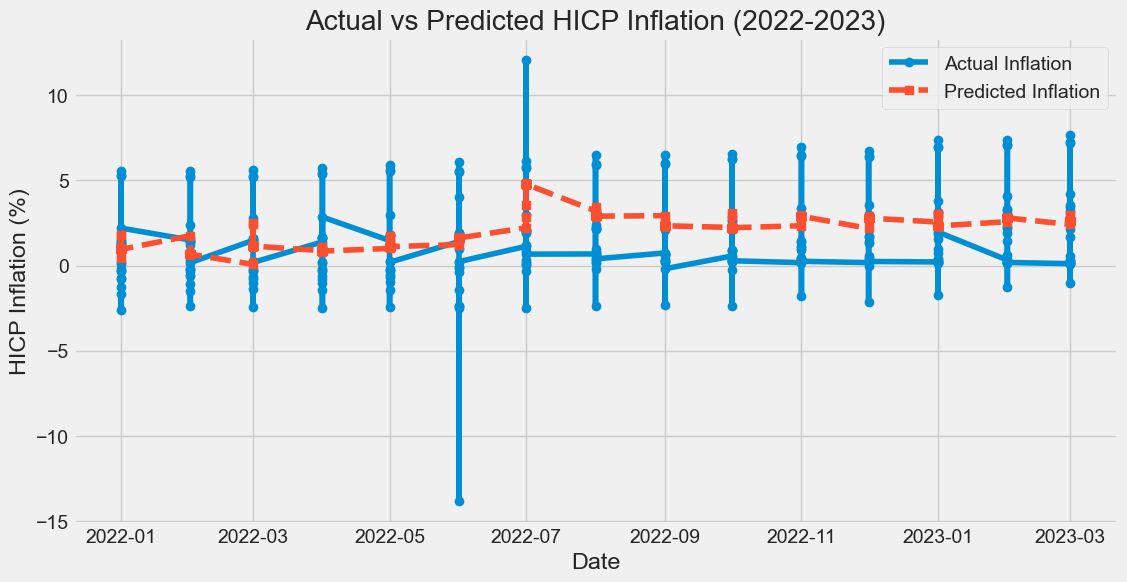

In [61]:
import matplotlib.pyplot as plt

# Create a DataFrame for visualization
results_df = test[["start_period", "HICP_inflation"]].copy()
results_df["Predicted_HICP"] = predictions  # Add predictions to DataFrame

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(results_df["start_period"], results_df["HICP_inflation"], label="Actual Inflation", marker="o")
plt.plot(results_df["start_period"], results_df["Predicted_HICP"], label="Predicted Inflation", marker="s", linestyle="dashed")

# Customize the plot
plt.xlabel("Date")
plt.ylabel("HICP Inflation (%)")
plt.title("Actual vs Predicted HICP Inflation (2022-2023)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


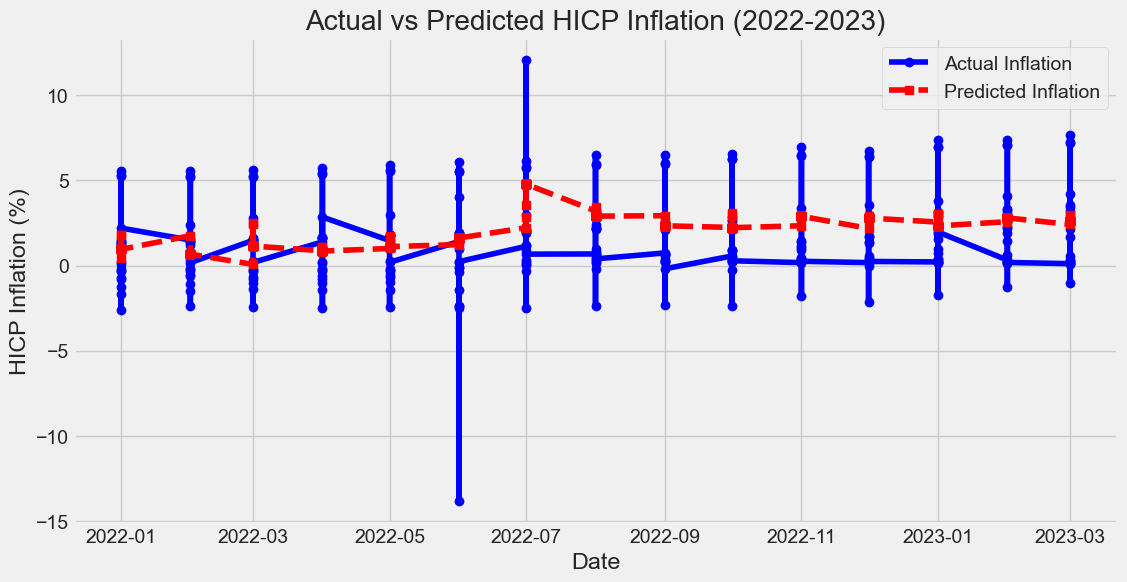

In [68]:
import matplotlib.pyplot as plt

# Ensure 'start_period' is datetime
test = test.copy()  # Avoid SettingWithCopyWarning
test.loc[:, 'start_period'] = pd.to_datetime(test['start_period'], errors='coerce')

# Make predictions using the trained model
predictions = model.predict(X_test)

# Create a DataFrame for visualization
results_df = test[["start_period", "HICP_inflation"]].copy()
results_df["Predicted_HICP"] = predictions  # Add predictions

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(results_df["start_period"], results_df["HICP_inflation"], label="Actual Inflation", marker="o", color="blue")
plt.plot(results_df["start_period"], results_df["Predicted_HICP"], label="Predicted Inflation", marker="s", linestyle="dashed", color="red")

# Customize the plot
plt.xlabel("Date")
plt.ylabel("HICP Inflation (%)")
plt.title("Actual vs Predicted HICP Inflation (2022-2023)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


df       start_period  M.AUD.EUR.SP00.A  M.BGN.EUR.SP00.A  M.CAD.EUR.SP00.A  \
0      2017-01-01          1.425159            1.9558          1.403200   
17     2017-01-01          1.425159            1.9558          1.403200   
16     2017-01-01          1.425159            1.9558          1.403200   
15     2017-01-01          1.425159            1.9558          1.403200   
14     2017-01-01          1.425159            1.9558          1.403200   
...           ...               ...               ...               ...   
1627   2023-12-01          1.632111            1.9558          1.465342   
1626   2023-12-01          1.632111            1.9558          1.465342   
1644   2023-12-01          1.632111            1.9558          1.465342   
1634   2023-12-01          1.632111            1.9558          1.465342   
1645   2023-12-01          1.632111            1.9558          1.465342   

      M.CHF.EUR.SP00.A  M.CNY.EUR.SP00.A  M.DKK.EUR.SP00.A  M.GBP.EUR.SP00.A  \
0             1

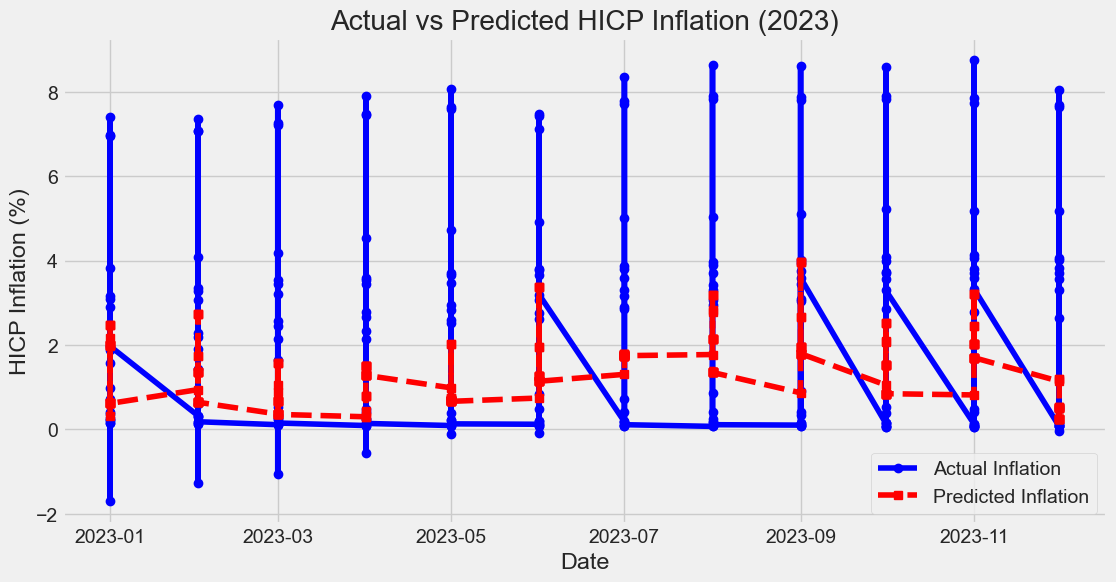

In [71]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

# Set style
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Load CSV files
df1 = pd.read_csv("C:/Users/marta/OneDrive/Робочий стіл/Economi_Indicators/data_pulls/bsi_data.csv")
df2 = pd.read_csv("C:/Users/marta/OneDrive/Робочий стіл/Economi_Indicators/data_pulls/exr_data.csv")
df3 = pd.read_csv("C:/Users/marta/OneDrive/Робочий стіл/Economi_Indicators/data_pulls/mir_data.csv")

# Combine datasets
ecb_data = pd.concat([df1, df2, df3], ignore_index=True)

# Extract HICP inflation data
hicp_data = df3[df3['dataset'] == 'MIR'].copy()
hicp_data = hicp_data[['start_period', 'OBS_value']].rename(columns={'OBS_value': 'HICP_inflation'})

# Convert start_period to datetime
ecb_data['start_period'] = pd.to_datetime(ecb_data['start_period'], errors='coerce')
hicp_data['start_period'] = pd.to_datetime(hicp_data['start_period'], errors='coerce')

# Drop NaT values
ecb_data.dropna(subset=['start_period'], inplace=True)
hicp_data.dropna(subset=['start_period'], inplace=True)

# Pivot dataset to have indicators as separate columns
ecb_pivot = ecb_data.pivot(index='start_period', columns='query', values='OBS_value').reset_index()

# Merge with HICP inflation data
ecb_pivot = pd.merge(ecb_pivot, hicp_data, on="start_period", how="inner")

# Sort by date
df = ecb_pivot.sort_values(by=["start_period"])

# Define target column (HICP inflation)
target_column = "HICP_inflation"

# Use all economic indicators as features
feature_columns = [col for col in df.columns if col not in ["start_period", target_column]]

# Drop rows where target value is NaN
df.dropna(subset=[target_column], inplace=True)
print('df ', df)
# **Create Lag Features for Forecasting**
lags = [1, 2, 3, 6, 12]  # Monthly lags for 1, 2, 3, 6, and 12 months
lagged_data = {f"{col}_lag_{lag}": df[col].shift(lag) for lag in lags for col in feature_columns}
lagged_df = pd.DataFrame(lagged_data)

# Concatenate lagged features to the main dataframe
df = pd.concat([df, lagged_df], axis=1)

# Drop NaN values caused by lagging

# Convert 'start_period' to datetime again (fix any remaining errors)
df['start_period'] = pd.to_datetime(df['start_period'], errors='coerce')
df.dropna(subset=['start_period'], inplace=True)

# **Train-Test Split: Training Until December 2022, Testing 2023**
train = df[df['start_period'] < pd.Timestamp("2023-01-01")]
test = df[df['start_period'] >= pd.Timestamp("2023-01-01")]

# Define training and testing features/target
X_train = train.drop(columns=["start_period", target_column])
y_train = train[target_column]

X_test = test.drop(columns=["start_period", target_column])
y_test = test[target_column]

df.dropna(inplace=True)

# Check if training & testing data are valid
if X_train.empty or X_test.empty:
    raise ValueError("No training or testing data available! Check dataset structure.")

# **Train XGBoost Model Using ALL Indicators**
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6
)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")

# **Plot Actual vs Predicted HICP Inflation**
results_df = test[["start_period", "HICP_inflation"]].copy()
results_df["Predicted_HICP"] = predictions  # Add predictions

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(results_df["start_period"], results_df["HICP_inflation"], label="Actual Inflation", marker="o", color="blue")
plt.plot(results_df["start_period"], results_df["Predicted_HICP"], label="Predicted Inflation", marker="s", linestyle="dashed", color="red")

# Customize the plot
plt.xlabel("Date")
plt.ylabel("HICP Inflation (%)")
plt.title("Actual vs Predicted HICP Inflation (2023)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
